<a href="https://colab.research.google.com/github/DesaData/DesaData/blob/main/Future_Stock_Market_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.models import Sequential #add layer by layer#
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping #stops training when a monitored metric has stopped improving & prevent overfitting#
from tensorflow.random import set_seed
from datetime import datetime
#By setting a random seed, you ensure that the sequence of random numbers can be reproduced.#
#This is crucial for experiments and research, where you need to ensure that results are consistent and reproducible.#
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

In [75]:
SEED = 123
set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
#initializing weights, generating synthetic data, or setting seeds for reproducibility#


In [76]:
df = pd.read_csv('Nasdaq data.csv')
#ensure its pd.to_datetime()#

df.sort_values(by="Date", ascending=True)
#df_sorted_desc = df.sort_values('Date', ascending=False) #for descending order#
df.head()

,Date,Close,Open,High,Low
0,12/3/2024,19480.91,19364.34,19486.15,19340.41
1,12/2/2024,19403.95,19255.42,19436.92,19255.42
2,11/29/2024,19218.17,19087.47,19245.49,19066.52
3,11/27/2024,19060.48,19132.99,19133.11,18937.20
4,11/26/2024,19175.58,19109.08,19184.40,19100.73


In [77]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Close,Open,High,Low
Date,,,,
2024-12-03,19480.91,19364.34,19486.15,19340.41
2024-12-02,19403.95,19255.42,19436.92,19255.42
2024-11-29,19218.17,19087.47,19245.49,19066.52
2024-11-27,19060.48,19132.99,19133.11,18937.20
2024-11-26,19175.58,19109.08,19184.40,19100.73


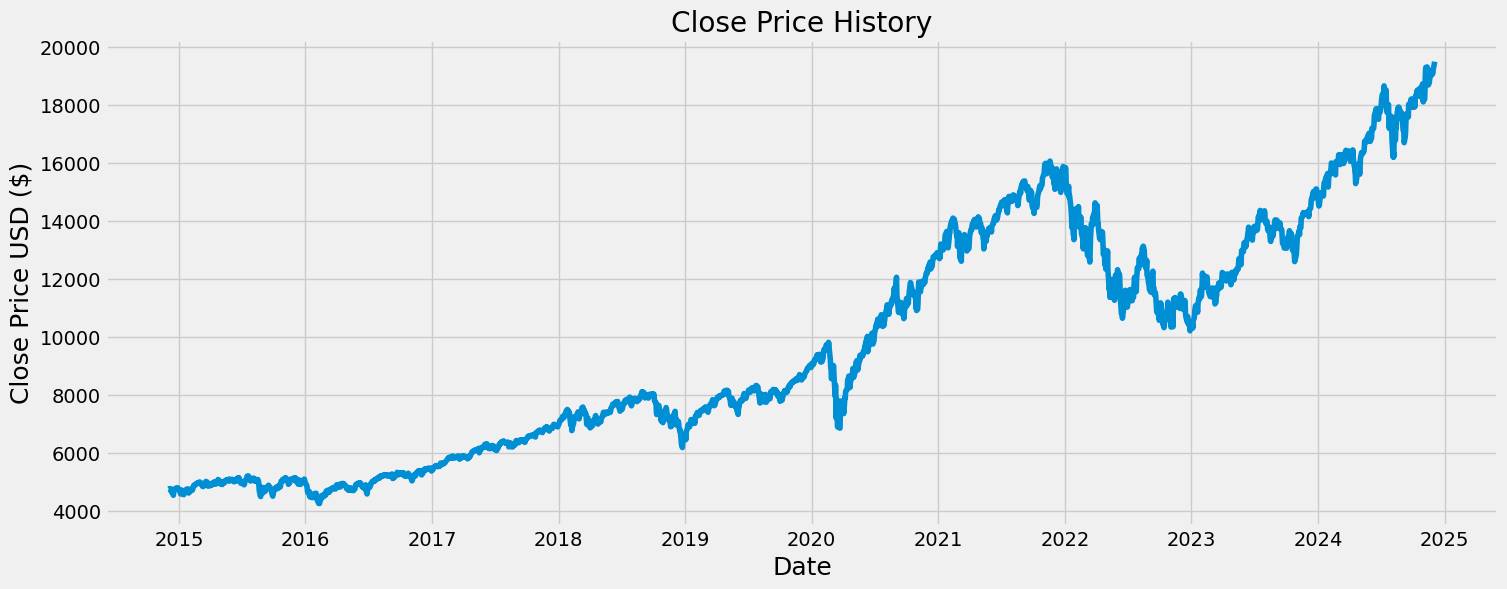

In [78]:
data = np.array(df["Close"]).reshape(-1, 1)

plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [79]:
# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_data

array([[1.        ],
       [0.99494152],
       [0.98273046],
       ...,
       [0.03114551],
       [0.03377926],
       [0.03303521]])

# Train

In [80]:
# Ratio of sample to use for training vs. testing
TRAIN_SIZE = 0.9 #90% of the data will be used for training and remaming 10% for data validation
#and testing 70-30 large and 80-20 medium data sets#

In [81]:
def get_model(window_size):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(window_size, 1)))#ensures a sequence hence True a layer is after#
    model.add(LSTM(64, return_sequences=False))#no laye ris after hence false#
    model.add(Dense(25))
    model.add(Dense(1))#these output layers use activation function linear activation function to output continous value)
    model.compile(optimizer='adam', loss='mean_squared_error') #Adam combines adagrad hence adjusts learning rate#
    return model

model = get_model(60)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
def convert_data(prediction_days_in_future, window_size):
    x = []
    y = []

    # Fetch 'WINDOW_SIZE' values as x and the value 'PREDICTION_TARGET' days later as y
    # Slide this window across all days to maximise values
    for i in range(window_size, len(data)-prediction_days_in_future):#create input-output pairs where input consists of a window of past data points& output the value of prediction#
        x.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i+prediction_days_in_future-1, 0])#the i index ensures we are days ahead of the current index i#

    x = np.array(x).reshape(len(x), window_size, 1)
    y = np.array(y)

    n_training_samples = int(len(y) * TRAIN_SIZE)
    X_train = x[:n_training_samples, :]
    y_train = y[:n_training_samples]
    X_test = x[n_training_samples:, :]
    y_test = y[n_training_samples:]

    return X_train, y_train, X_test, y_test, n_training_samples

def plot_results(train, output):
    plt.figure(figsize=(16, 6))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(output[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

In [83]:
def fit_model(days_in_future, window_size):
    print(f"Predicting for {days_in_future} days in future...")
    #fit model uses uses Long Short-Term Memory (LSTM) neural networks for data prediction)

    X_train, y_train, X_test, y_test, n_training_samples = convert_data(days_in_future, window_size)
    #Prepares the dataset for the LSTM model.#
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
    #Reverses the scaling on the test set to interpret the predictions correctly.#
    print("Train samples:", len(y_train), "Test samples:", len(y_test))

    # Fit model
    model = get_model(window_size)
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=15,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
    )

    # Get the models predicted price values
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test_original) ** 2)))
    print("RMSE:", rmse)

    # Mean absolute percentage error
    mape = mean_absolute_percentage_error(y_test_original, predictions)
    print("Mean Absolute Percentage Error:", mape)

    # Final prediction error
    error = (np.abs(predictions[-1] - y_test_original[-1]) / y_test_original[-1])[0]
    print("Final Prediction Error:", error)

    # Plot results
    train = df[:n_training_samples+window_size+days_in_future-1]
    output = df[n_training_samples+window_size+days_in_future-1:-1]

    output['Predictions'] = predictions
    plot_results(train, output)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Predicting for 10 days in future...
Train samples: 2210 Test samples: 246
Epoch 1/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - loss: 0.0370 - val_loss: 3.5552e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - loss: 0.0014 - val_loss: 1.0580e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 0.0011 - val_loss: 9.5627e-05
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - loss: 0.0012 - val_loss: 9.1430e-05
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - loss: 0.0012 - val_loss: 8.7556e-05
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - loss: 0.0012 - val_loss: 8.6834e-05
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.0012 - val_loss: 8.6843e-05
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - loss: 0.0011 - val_loss: 8.8384e-05
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - loss: 0.0011 - val_loss: 9.0583e-05
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
RMSE: 144.79997981401928
Mean Absolute Percentage Error: 0.0220017738328

<ipython-input-83-82a63f66bf18>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions'] = predictions


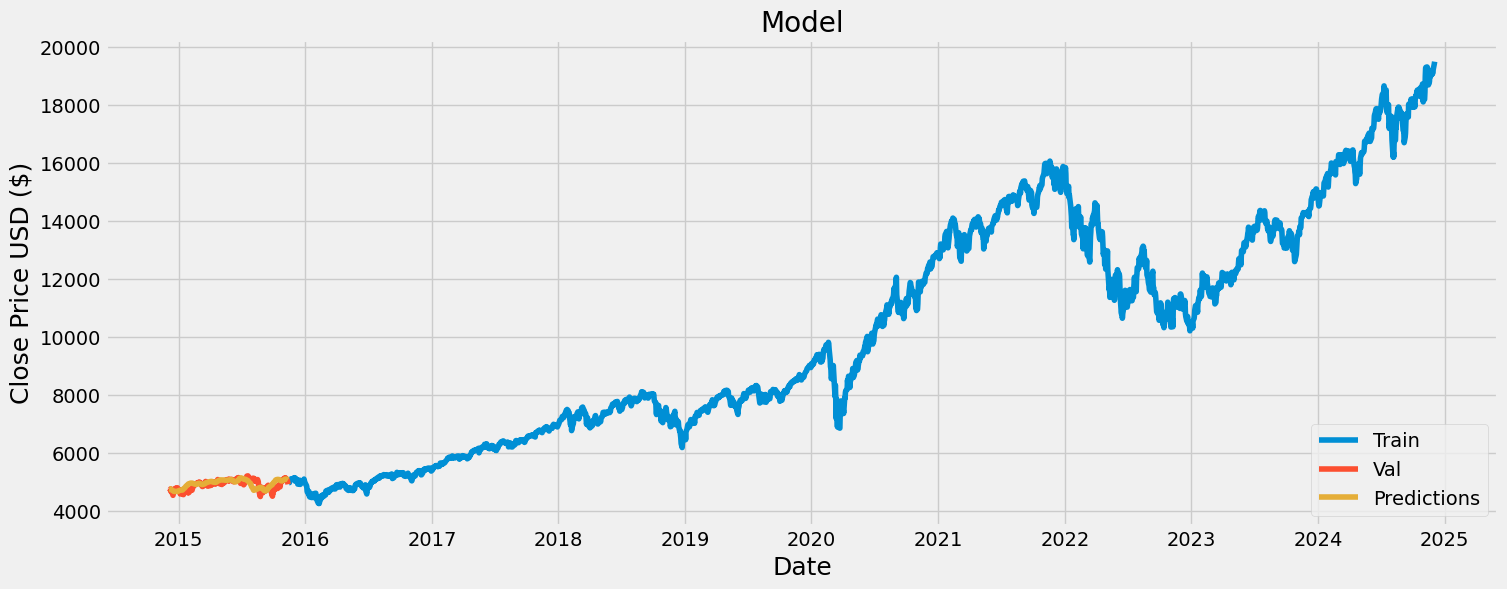

In [84]:
fit_model(days_in_future=10, window_size=60)

# Try different date scopes

Predicting for 7 days in future...
Train samples: 2213 Test samples: 246
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - loss: 0.0451 - val_loss: 3.3711e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.0013 - val_loss: 9.1691e-05
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - loss: 9.4128e-04 - val_loss: 7.8172e-05
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 8.9587e-04 - val_loss: 7.6765e-05
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - loss: 8.9338e-04 - val_loss: 7.6566e-05
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 8.8994e-04 - val_loss: 7.6500e-05
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - loss: 8.8742e-04 - val_loss: 7.6346e-05
Epoch 8/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - loss: 8.8492e-04 - val_loss: 7.6013e-05
Epoch 9/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 8.8207e-04 - val_loss: 7.5769e-05
Epoch 10/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 232ms/step - loss: 8.8010e-04 - val_loss: 7.5626e-05
Epoch 11/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 8.7919e-04 - v

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
RMSE: 131.89591011714663
Mean Absolute Percentage Error: 0.020901555642169792
Final Prediction Error: 0.010261721593428705


<ipython-input-83-82a63f66bf18>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions'] = predictions


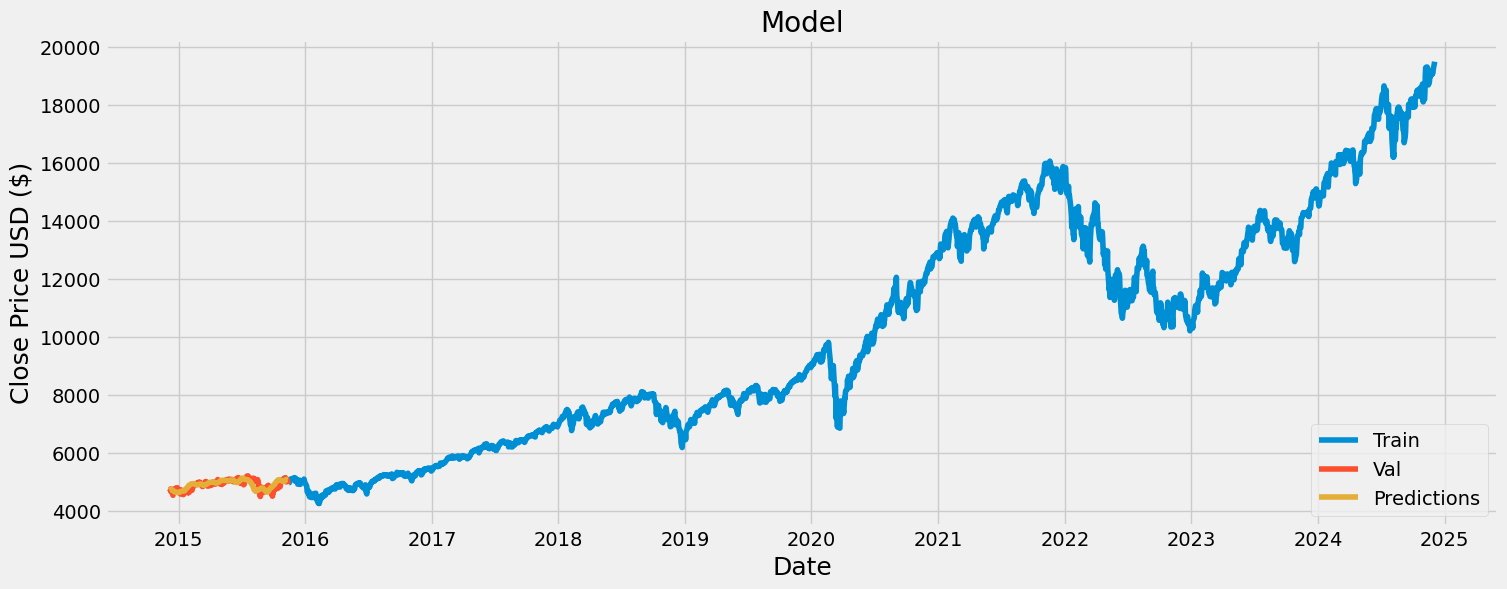

In [85]:
fit_model(days_in_future=7, window_size=60)

Predicting for 30 days in future...
Train samples: 2192 Test samples: 244
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - loss: 0.0545 - val_loss: 4.2153e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - loss: 0.0027 - val_loss: 1.9191e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - loss: 0.0024 - val_loss: 1.8806e-04
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - loss: 0.0024 - val_loss: 2.0085e-04
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - loss: 0.0024 - val_loss: 2.1305e-04
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.0024 - val_loss: 2.2898e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
RMSE: 230.22082454259146
Mean Absolute Percentage Error: 0.04020963668101775
Final Prediction Error: 0.004368552280390611


<ipython-input-83-82a63f66bf18>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions'] = predictions


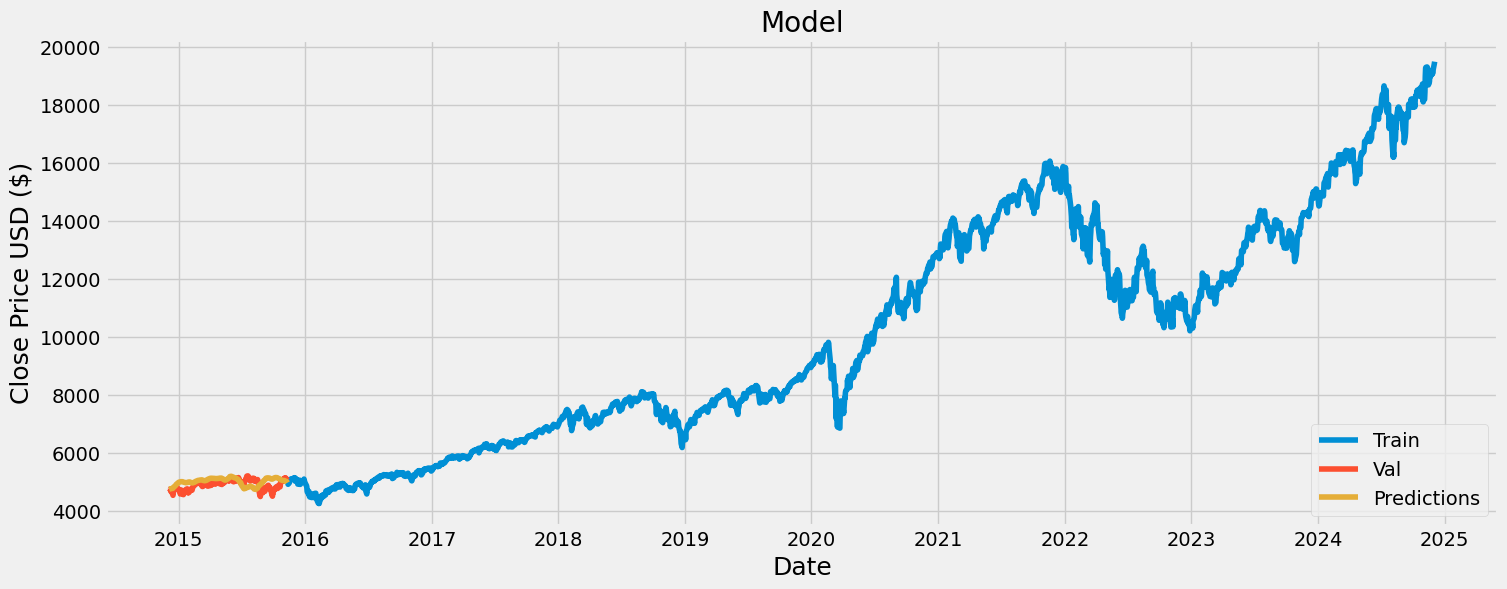

In [86]:
fit_model(days_in_future=30, window_size=60)

Predicting for 7 days in future...
Train samples: 2240 Test samples: 249
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0401 - val_loss: 1.8087e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - loss: 0.0012 - val_loss: 1.0267e-04
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 8.1911e-04 - val_loss: 7.5916e-05
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 7.7529e-04 - val_loss: 7.6138e-05
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - loss: 7.7261e-04 - val_loss: 7.6883e-05
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 7.6646e-04 - val_loss: 7.8269e-05
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
RMSE: 134.5982419883433
Mean Absolute Percentage Error: 0.02130623875534238
Final Prediction Error: 0.005395209783590939


<ipython-input-83-82a63f66bf18>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions'] = predictions


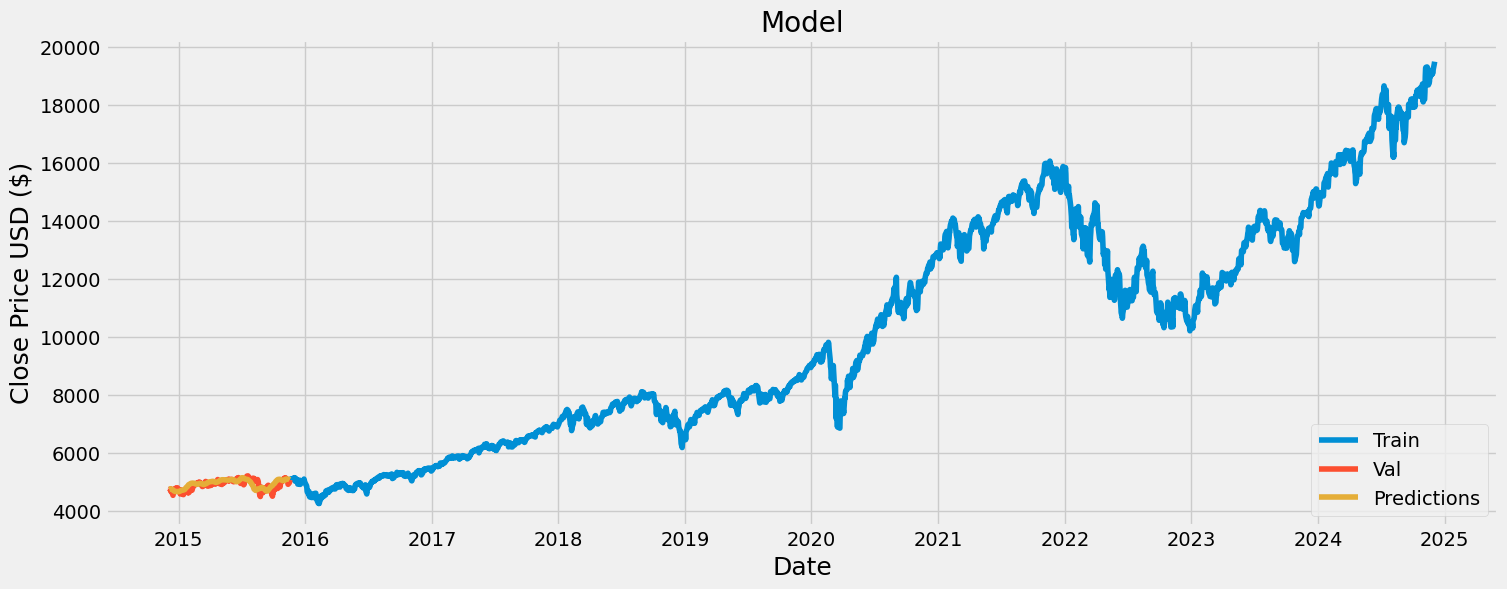

In [87]:
fit_model(days_in_future=7, window_size=30)

Predicting for 7 days in future...
Train samples: 2186 Test samples: 243
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - loss: 0.0464 - val_loss: 1.7726e-04
Epoch 2/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 304ms/step - loss: 0.0012 - val_loss: 8.8728e-05
Epoch 3/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - loss: 9.2817e-04 - val_loss: 7.9539e-05
Epoch 4/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - loss: 8.8416e-04 - val_loss: 7.7075e-05
Epoch 5/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 307ms/step - loss: 8.7826e-04 - val_loss: 7.7171e-05
Epoch 6/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 294ms/step - loss: 8.7358e-04 - val_loss: 7.8732e-05
Epoch 7/15
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 304ms/step - loss: 8.6783e-04 - val_loss: 8.2376e-05
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
RMSE: 138.08505738515976
Mean Absolute Percentage Error: 0.021880649082688483
Final Prediction Error: 0.00218899884641777


<ipython-input-83-82a63f66bf18>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output['Predictions'] = predictions


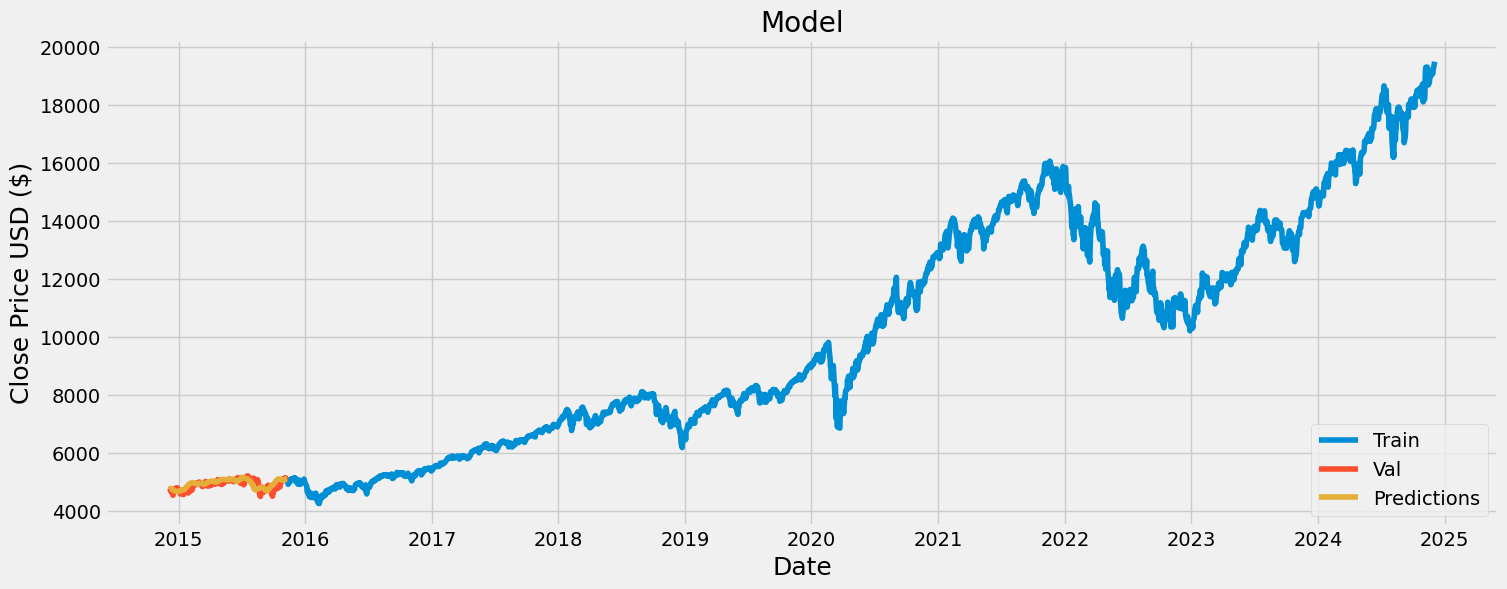

In [88]:
fit_model(days_in_future=7, window_size=90)